# 1.0 Data Wrangling

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

In [1]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Calculating Rate of Professional AirBnB hosts by LSOA

### 1.1.1 Read in data

In [2]:
# Reading in listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [3]:
#Reading in the Lower Super Output Area (LSOA) shapefile
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

### 1.1.2 Identify professional listings

In [4]:
#Converting the total_listing_count column to numpy array for manipulation
host_count = np.array(listings['host_total_listings_count'].values.tolist())

In [5]:
host_count[host_count > 1] = 0 #Changing any values above 1 to 0. Meaning "not casual" (professional).

In [6]:
listings['casual_or_prof'] = host_count #Creating a new column which identifies if a listings host is casual (1 listing), or professional (>1 listing)


|  | Professional | Non-Professional (Casual)|
| --- | --- | --- |
| **Listing Count** | > 1 |1 |

### 1.1.3 Convert to same CRS

In [7]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

### 1.1.4 Spatial Join listings to LSOAs (spatial aggregation unit)

In [8]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [9]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
professional_count = lsoa_ls.groupby(["LSOA_CODE", "casual_or_prof"])["count"].sum().reset_index()
professional_count

,LSOA_CODE,casual_or_prof,count
0,E01000001,0,10
1,E01000001,1,4
2,E01000002,0,4
3,E01000002,1,4
4,E01000003,0,13
...,...,...,...
7809,E01004763,1,43
7810,E01004764,0,256
7811,E01004764,1,31
7812,E01004765,0,107


In [10]:
host_lsoa = professional_count.groupby("LSOA_CODE")["count"].sum().reset_index() #Total number of hosts per LSOA
# host_lsoa

In [11]:
#Identifying hosts that are professional (more than one listing)
prop_count = professional_count[professional_count["casual_or_prof"] ==0].rename(columns={"count":"professional_count"}).merge(host_lsoa.rename(columns={"count":"total_count"}), on="LSOA_CODE", how="right")
# prop_count

In [12]:
#Calculating the proportion of professional AirBnB hosts to total hosts per LSOA
prop_count["prop"] = prop_count["professional_count"] / prop_count["total_count"]

In [13]:
#Merging this proportion with the overall spatially referenced LSOA data
lsoa_prop = lsoa.merge(prop_count, how="left", on="LSOA_CODE")

In [14]:
lsoa_prop
#prop_count

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual_or_prof,professional_count,total_count,prop
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286
1,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000
2,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,13.0,19.0,0.684211
3,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",0.0,210.0,257.0,0.817121
4,E01000005,City of London 001E,E02000001,City of London 001,00AAFX,Portsoken,00AA,City of London,"POLYGON ((533378.878 181459.767, 533439.561 18...",0.0,100.0,120.0,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,E01004761,Westminster 018D,E02000977,Westminster 018,00BKGW,West End,00BK,Westminster,"POLYGON ((528459.247 180541.840, 528440.441 18...",0.0,196.0,213.0,0.920188
4761,E01004762,Westminster 011E,E02000970,Westminster 011,00BKGW,West End,00BK,Westminster,"POLYGON ((528043.878 180619.098, 527888.747 18...",0.0,85.0,95.0,0.894737
4762,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",0.0,328.0,371.0,0.884097
4763,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,256.0,287.0,0.891986


In [15]:
#Calculate the area of each LSOA in km2
lsoa_prop['area'] = lsoa_prop.geometry.area/1000

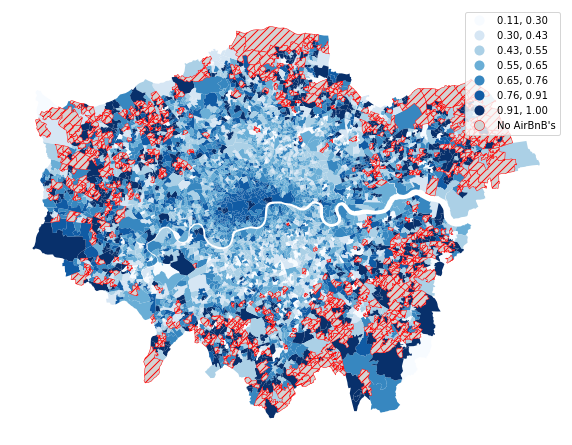

In [16]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_prop.plot(column="prop", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues",
               missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5))

plt.axis("off")

plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

## 1.3 Cultural Infrastructure
### 1.3.1 Read in data

In [17]:
#Import data
cultural = pd.read_csv('data/cultural-infrastructure-map-all-sites.csv')
print(f'Rows, Columns = {cultural.shape}')

#Clean column name
cultural.rename(columns = {'Cultural Venue Type':'venue_type'}, 
                   inplace = True)

# print(cultural.dtypes)
cultural.head(5)

Rows, Columns = (10003, 29)


,BOROUGH,venue_type,additional_contact_name,address1,address2,address3,alternativenames,borough_code,borough_name,building_name,...,rm_organisation_name,runtime,site_name,ward,ward_2018_code,ward_2018_name,ward_code,ward_code_2018,ward_name_2018,website
0,Tower Hamlets,Archives,NaN,Thomson Reuters,30 South Colonnade,Canary Wharf,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Reuters Archive,NaN,E05009323,Canary Wharf,NaN,NaN,NaN,https://reuters.screenocean.com/
1,Tower Hamlets,Archives,NaN,Whitechapel High Street,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Whitechapel Art Gallery,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.whitechapelgallery.org/
2,Tower Hamlets,Archives,NaN,37 Spital Square,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Society for the Protection of Ancient Buildings,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.spab.org.uk/
3,Tower Hamlets,Archives,NaN,Watson House,54 Baker Street,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Lasa,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,http://www.lasa.org.uk/
4,Tower Hamlets,Archives,NaN,Graces Alley,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Wilton's Music Hall,NaN,E05009336,Whitechapel,NaN,NaN,NaN,https://www.wiltons.org.uk/


In [18]:
#Convert to spatial object (geopandas)
gdf_cultural = gpd.GeoDataFrame(cultural, 
      geometry=gpd.points_from_xy(cultural.longitude, cultural.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_cultural = gdf_cultural.to_crs(lsoa.crs)
gdf_cultural.shape

(10003, 30)

### 1.3.2 Join points to LSOAs

In [19]:
#Spatially joining the LSOA to each cultural point
gdf_cultural = gdf_cultural.sjoin(lsoa, predicate="within")

### 1.3.3 Reading in CEZ data

In [20]:
import glob

# Get multiple CSV from folder into 1 csv
path = 'data/site_by_cez'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
cez_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
cez = pd.concat(cez_list, ignore_index=True)

cez.rename(columns = {'Cultural Venue Type':'venue_type', 'Creative Enterprise Zones': 'cez'}, 
                   inplace = True)

In [21]:
#Convert to spatial object (geopandas)
gdf_cez = gpd.GeoDataFrame(cez, 
      geometry=gpd.points_from_xy(cez.longitude, cez.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_cez = gdf_cez.to_crs(lsoa.crs)
gdf_cez.shape

(608, 18)

### 1.3.4 Join CEZ points to LSOA

In [22]:
#Spatially joining the LSOA to each cultural point
gdf_cez = gdf_cez.sjoin(lsoa, predicate="within")
gdf_cez["clt_type"] = 0
gdf_cez.shape

(587, 28)

### 1.3.5 Merge CEZ data and cultural data

Clean both datasets to have the same columns and column names (to ensure clean append)

In [23]:
# print(gdf_cultural.dtypes)
# print(gdf_cez.dtypes)

# Select desired columns from 'gdf_cultural'
gdf_cult_select = gdf_cultural[['venue_type',
                                'borough_code',
                                'borough_name',
                                'LSOA_CODE',
                                'LSOA_NAME',
                                'latitude',
                                'longitude',
                                'easting',
                                'northing',
                                'site_name']]

print(gdf_cult_select.shape)

gdf_cez_select = gdf_cez[['venue_type',
                                'borough_code',
                                'borough_name',
                                'LSOA_CODE',
                                'LSOA_NAME',
                                'latitude',
                                'longitude',
                                'easting',
                                'northing',
                                'site_name',
                                'clt_type']]

print(gdf_cez_select.shape)

(9988, 10)
(587, 11)


In [24]:
cultural_all = gdf_cult_select.append(gdf_cez_select, ignore_index = True)
# cultural_all = pd.concat(gdf_cultural, gdf_cez, ignore_index = True)

cultural_all.shape

/tmp/ipykernel_1494/1011088018.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cultural_all = gdf_cult_select.append(gdf_cez_select, ignore_index = True)


(10575, 11)

### 1.3.6 Check for duplicates

Some venues are listed under multiple categories (e.g. pub and music venue); therefore need to limit each unique venue to a single observation. Additionally, need to remove rows which are not relevant to the analysis. 

- Include location in identification of duplicates (select on 'site_name' + 'lat/long')

In [25]:
#Remove irrelavant cultural points
values = ['Community centres'
          # , 'Pubs'
          , 'Large media production studios', 'Libraries', 'Music (office based businesses)']

cultural_clean = cultural_all[cultural_all.venue_type.isin(values) == False]
cultural_clean.shape

(8963, 11)

In [26]:
#Use site_name, easting and northing to identify unique venues

# HOWEVER, due to geocoding discrepancies, some records that are clearly a single venue have slightly different easting/northing values
# THEREFORE, create a new variable that is 'rough' easting/northing, that is only accurate to ~100m
# USE these new fuzzy e/n variables as the identification field for duplicates

# Create new easting/northing vars
cultural_clean['easting_fuzzy'] = round(cultural_clean.easting/100)
cultural_clean['northing_fuzzy'] = round(cultural_clean.northing/100)

cultural_clean.drop_duplicates(subset = ["site_name", "easting_fuzzy", "northing_fuzzy"], keep = 'first', inplace = True, ignore_index = True)
cultural_clean.shape

/tmp/ipykernel_1494/819237703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cultural_clean['easting_fuzzy'] = round(cultural_clean.easting/100)
/tmp/ipykernel_1494/819237703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cultural_clean['northing_fuzzy'] = round(cultural_clean.northing/100)
/tmp/ipykernel_1494/819237703.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

(8059, 13)

### 1.3.7 Cultural Infrastructure Classification

In [27]:
#Classification
low = ['Arts centres', 'Cinemas', 'Creative co-working desk space', 'Creative workspaces',
       'Legal street art walls', 'LGBT+ night time venues', 'Live in artists’ workspace',
       'Makerspaces', 'Making and manufacturing', 'Music recording studios', 'Music rehearsal studios',
       'Artists workspaces', 'Dance rehearsal studios', 'Music venues (grassroots)', 'Prop and costume making',
       'Set and exhibition building', 'Skate Parks', 'Textile design', 'Theatre rehearsal studio',
       'Fashion and design', 'Jewellery design', 'Archives']

high = ['Commercial galleries', 'Museums and public galleries', 'Theatres', 'Dance performance venues',
        'Music venues (all)']

cultural_clean.loc[cultural_clean["clt_type"].isnull(),"clt_type"] = '1' 
cultural_clean.loc[cultural_clean["venue_type"].isin(low) , "clt_type"] = "0"

/tmp/ipykernel_1494/3937962669.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cultural_clean.loc[cultural_clean["clt_type"].isnull(),"clt_type"] = '1'


### 1.3.8 Find number of high/low culture per LSOA

In [28]:
#Number of high v low Airbnb hosts by LSOA
cultural_clean["count"] = 1
highlow_count = cultural_clean.groupby(["LSOA_CODE", "clt_type"])["count"].sum().reset_index()
highlow_count

/tmp/ipykernel_1494/3689269293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cultural_clean["count"] = 1


,LSOA_CODE,clt_type,count
0,E01000001,0,6
1,E01000001,1,6
2,E01000002,0,9
3,E01000002,1,13
4,E01000003,1,3
...,...,...,...
2823,E01004763,1,89
2824,E01004764,0,35
2825,E01004764,1,109
2826,E01004765,0,14


In [29]:
#Total cultural points
count_by_lsoa = highlow_count.groupby("LSOA_CODE")["count"].sum().reset_index() #Total number of cultural points per LSOA

count_by_lsoa.head(5)

,LSOA_CODE,count
0,E01000001,12
1,E01000002,22
2,E01000003,3
3,E01000004,270
4,E01000005,19


In [30]:
#Identifying high and low cultural points per lsoa
cult_count = highlow_count.rename(columns={"count":"high_count"}).drop(labels='clt_type', axis=1).merge(count_by_lsoa.rename(columns={"count":"total_clt_count"}), on="LSOA_CODE", how="right")
cult_count["low_count"] = cult_count['total_clt_count'] - cult_count['high_count']

In [31]:
cult_count

,LSOA_CODE,high_count,total_clt_count,low_count
0,E01000001,6,12,6
1,E01000001,6,12,6
2,E01000002,9,22,13
3,E01000002,13,22,9
4,E01000003,3,3,0
...,...,...,...,...
2823,E01004763,89,109,20
2824,E01004764,35,144,109
2825,E01004764,109,144,35
2826,E01004765,14,39,25


In [32]:
#Merge sum per LSOA back with the overall spatially referenced LSOA data
lsoa_clt = lsoa_prop.merge(cult_count, how="left", on="LSOA_CODE")

In [33]:
# Calculate density of cultural points 

lsoa_clt['clt_low_density'] = lsoa_clt.low_count/lsoa_clt.area*10000

lsoa_clt['clt_high_density'] = lsoa_clt.high_count/lsoa_clt.area*10000

lsoa_clt['clt_total_density'] = lsoa_clt.total_clt_count/lsoa_clt.area*10000


In [34]:
lsoa_clt.head()

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual_or_prof,professional_count,total_count,prop,area,high_count,total_clt_count,low_count,clt_low_density,clt_high_density,clt_total_density
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,6.0,12.0,6.0,0.450466,0.450466,0.900933
1,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,6.0,12.0,6.0,0.450466,0.450466,0.900933
2,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,9.0,22.0,13.0,0.575663,0.398536,0.974199
3,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,13.0,22.0,9.0,0.398536,0.575663,0.974199
4,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,13.0,19.0,0.684211,58.276984,3.0,3.0,0.0,0.000000,0.514783,0.514783


(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

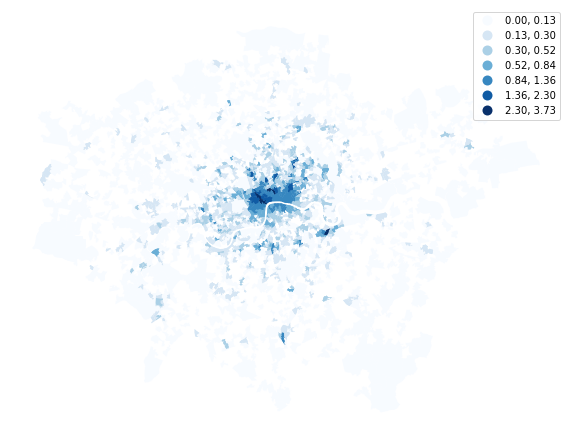

In [35]:
# Mapping density of cultural venues per LSOA
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="clt_total_density", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )
plt.axis("off")

(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

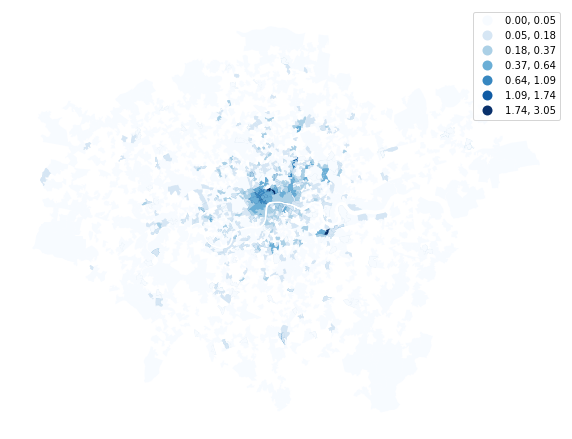

In [36]:
# Mapping density of low cultural venues per LSOA
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="clt_low_density", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )
plt.axis("off")

(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

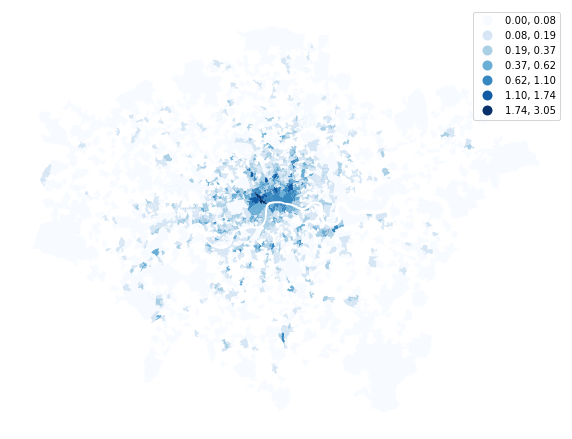

In [37]:
# Mapping density of high cultural venues per LSOA
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="clt_high_density", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )
plt.axis("off")

In [38]:
lsoa_clt

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual_or_prof,professional_count,total_count,prop,area,high_count,total_clt_count,low_count,clt_low_density,clt_high_density,clt_total_density
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,6.0,12.0,6.0,0.450466,0.450466,0.900933
1,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,10.0,14.0,0.714286,133.195257,6.0,12.0,6.0,0.450466,0.450466,0.900933
2,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,9.0,22.0,13.0,0.575663,0.398536,0.974199
3,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,4.0,8.0,0.500000,225.826619,13.0,22.0,9.0,0.398536,0.575663,0.974199
4,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,13.0,19.0,0.684211,58.276984,3.0,3.0,0.0,0.000000,0.514783,0.514783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",0.0,328.0,371.0,0.884097,292.141711,89.0,109.0,20.0,0.684599,3.046467,3.731066
5415,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,256.0,287.0,0.891986,624.734704,35.0,144.0,109.0,1.744741,0.560238,2.304978
5416,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,256.0,287.0,0.891986,624.734704,109.0,144.0,35.0,0.560238,1.744741,2.304978
5417,E01004765,Westminster 013D,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((528673.190 181605.785, 528661....",0.0,107.0,122.0,0.877049,263.038327,14.0,39.0,25.0,0.950432,0.532242,1.482674


## 1.2 Gentrification Classifications (Yee and Dennett, 2020)

This is just a simple binary classification of areas that are predicted to gentrify vs areas that are not.

In [39]:
#Import data
gent = pd.read_csv('data/predictions_modelling1.csv')
print(f'Rows, Columns = {gent.shape}')
print(gent.dtypes)

Rows, Columns = (4835, 130)
Unnamed: 0          int64
LSOA11CD           object
Pop_size          float64
age_0_4           float64
age_5_7           float64
                   ...   
toWork_taxi       float64
toWork_bicycle    float64
toWork_walk       float64
toWork_other      float64
predictions        object
Length: 130, dtype: object


In [40]:
lsoa_clt_gent = lsoa_clt.merge(gent[['LSOA11CD', 'predictions']], how = "left", left_on = "LSOA_CODE", right_on = "LSOA11CD")

(500655.06033394457, 564875.8132172046, 153596.66716660303, 203187.7528659835)

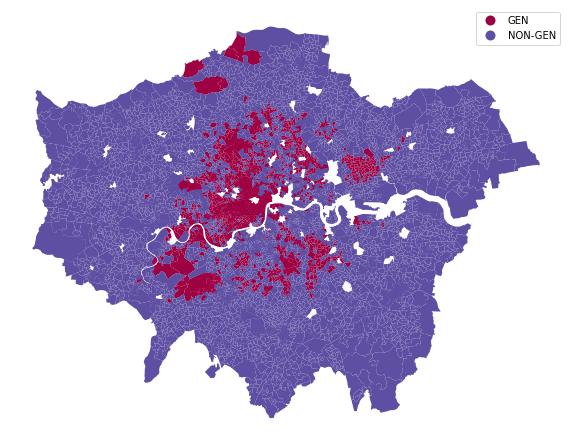

In [41]:
#Quick map showing gentrifying/non-gentrifying LSOAs
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt_gent.plot(column="predictions", categorical = True, legend=True, ax=ax, cmap="Spectral")

plt.axis("off")

This is a more stratified classification of areas that are gentrifying and how

In [42]:
#Import data
gent_strat = pd.read_csv('data/LSOA_labels_forMapping.csv')
print(f'Rows, Columns = {gent_strat.shape}')
print(gent_strat.dtypes)

Rows, Columns = (4835, 5)
Unnamed: 0         int64
LSOA_Code         object
Class_1_status    object
Class_2_status    object
Class_3_status    object
dtype: object


In [43]:
lsoa_strat_gent = lsoa_clt.merge(gent_strat, how = "left", left_on = "LSOA_CODE", right_on = "LSOA_Code")

(500655.06033394457, 564875.8132172046, 153596.66716660303, 203187.7528659835)

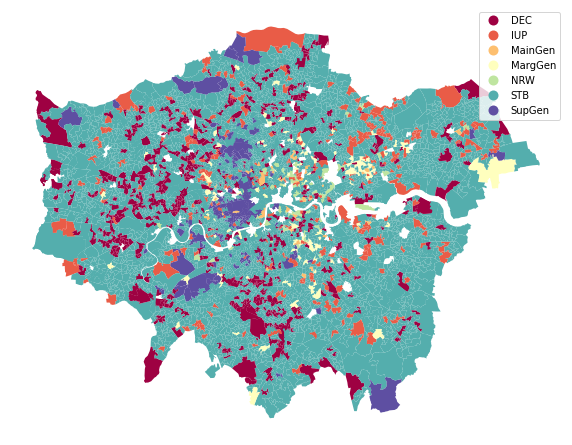

In [44]:
#Quick map showing gentrifying/non-gentrifying LSOAs
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_strat_gent.plot(column="Class_3_status", categorical = True, legend=True, ax=ax, cmap="Spectral")

plt.axis("off")

## 1.2.2 Start of logistic regression
Beginnings of logistic regression

In [45]:
lsoa_dummies = lsoa_clt_gent.merge(pd.get_dummies(lsoa_clt_gent[['predictions']]), left_index = True, right_index = True, how = "left")
lsoa_dummies

,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,casual_or_prof,...,high_count,total_clt_count,low_count,clt_low_density,clt_high_density,clt_total_density,LSOA11CD,predictions,predictions_GEN,predictions_NON-GEN
0,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,...,6.0,12.0,6.0,0.450466,0.450466,0.900933,E01000001,GEN,1,0
1,E01000001,City of London 001A,E02000001,City of London 001,00AAFA,Aldersgate,00AA,City of London,"POLYGON ((532050.879 181817.674, 532021.188 18...",0.0,...,6.0,12.0,6.0,0.450466,0.450466,0.900933,E01000001,GEN,1,0
2,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,...,9.0,22.0,13.0,0.575663,0.398536,0.974199,E01000002,NON-GEN,0,1
3,E01000002,City of London 001B,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532267.748 181643.784, 532254.565 18...",0.0,...,13.0,22.0,9.0,0.398536,0.575663,0.974199,E01000002,NON-GEN,0,1
4,E01000003,City of London 001C,E02000001,City of London 001,00AAFQ,Cripplegate,00AA,City of London,"POLYGON ((532071.310 182159.597, 532135.127 18...",0.0,...,3.0,3.0,0.0,0.000000,0.514783,0.514783,E01000003,NON-GEN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,E01004763,Westminster 013B,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((529156.425 181706.116, 529157....",0.0,...,89.0,109.0,20.0,0.684599,3.046467,3.731066,E01004763,GEN,1,0
5415,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,...,35.0,144.0,109.0,1.744741,0.560238,2.304978,NaN,NaN,0,0
5416,E01004764,Westminster 013C,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"POLYGON ((528561.997 181004.997, 528464.129 18...",0.0,...,109.0,144.0,35.0,0.560238,1.744741,2.304978,NaN,NaN,0,0
5417,E01004765,Westminster 013D,E02000972,Westminster 013,00BKGW,West End,00BK,Westminster,"MULTIPOLYGON (((528673.190 181605.785, 528661....",0.0,...,14.0,39.0,25.0,0.950432,0.532242,1.482674,E01004765,GEN,1,0


In [46]:
from sklearn import linear_model
lsoa_dummies = lsoa_dummies.dropna()
X = np.array(lsoa_dummies['prop']).reshape(-1, 1)
y = np.array(lsoa_dummies['predictions_GEN'])
logr = linear_model.LogisticRegression()
logr.fit(X,y)


LogisticRegression()

<AxesSubplot:xlabel='prop', ylabel='Density'>

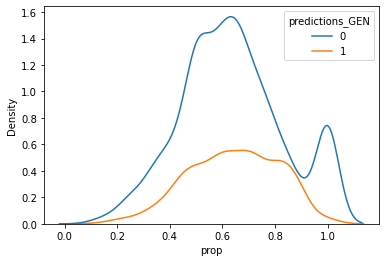

In [47]:
sns.kdeplot(data = lsoa_dummies, hue = 'predictions_GEN', x = 'prop')

In [48]:
log_odds = logr.coef_
odds = np.exp(log_odds)

print(odds)

[[1.15680102]]


## 1.3 Output cleaned data for analysis

In [63]:
# Save dataframe to data folder

lsoa_strat_gent.to_csv("data/lsoa_strat_gent.csv")